In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import keras
keras.__version__

'2.13.1'

In [3]:
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# First, transform the input into a 16x16 128-channels feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# Then, add a convolution layer
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsample to 32x32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# Few more conv layers
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Produce a 32x32 1-channel feature map
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 256)       104883

In [13]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# One dropout layer - important trick!
x = layers.Dropout(0.4)(x)

# Classification layer
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
discriminator_optimizer = keras.optimizers.RMSprop(learning_rate=0.0008, clipvalue=1.0)

discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 30, 30, 128)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 6, 6, 128)         0   

In [15]:
# Set discriminator weights to non-trainable
# (will only apply to the `gan` model)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(learning_rate=0.0004, clipvalue=1.0)

gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')


In [ ]:
import os
from keras.preprocessing import image

# Load CIFAR10 data
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Select frog images (class 6)
x_train = x_train[y_train.flatten() == 6]

# Normalize data
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = r'C:\Users\Susanta Baidya\Downloads'

# Start training loop
start = 0
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator.predict(random_latent_vectors)

    # Combine them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan.save_weights('gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # Save one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # Save one real image, for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))


1/1 [==============================] - 1s 1s/step
discriminator loss at step 0: 0.7144333124160767
adversarial loss at step 0: 4.999882221221924
1/1 [==============================] - 3s 3s/step
discriminator loss at step 100: 0.6899444460868835
adversarial loss at step 100: 0.7476518750190735
1/1 [==============================] - 3s 3s/step
discriminator loss at step 200: 0.7082468271255493
adversarial loss at step 200: 0.7424348592758179
1/1 [==============================] - 3s 3s/step
discriminator loss at step 300: 0.7019432783126831
adversarial loss at step 300: 0.791556715965271
1/1 [==============================] - 3s 3s/step
discriminator loss at step 400: 0.693060576915741
adversarial loss at step 400: 0.781859278678894
1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 1s 610ms/step


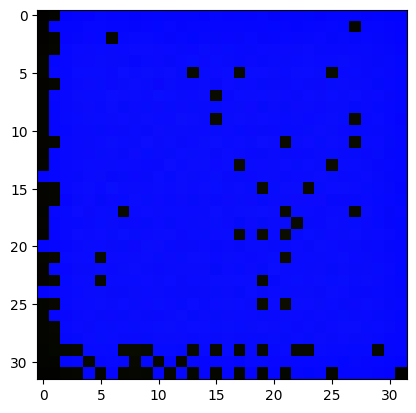

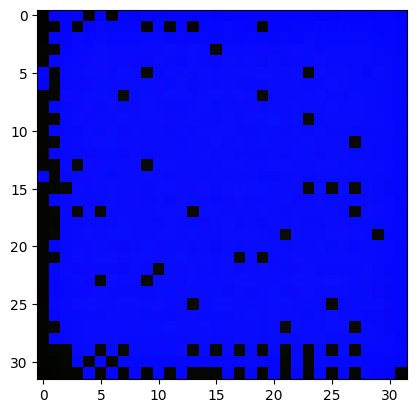

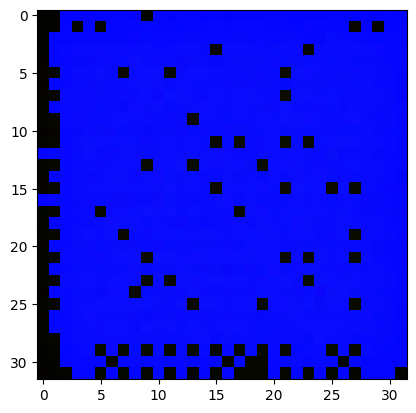

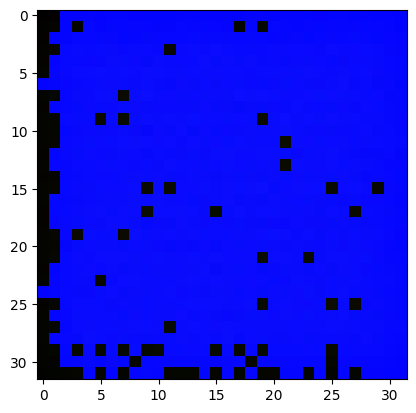

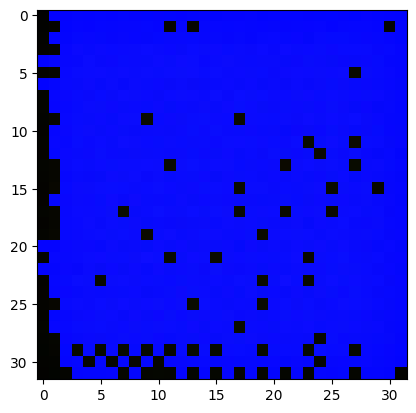

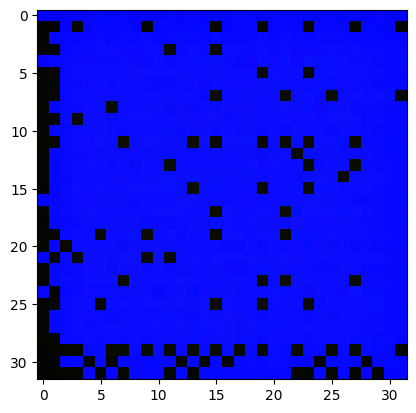

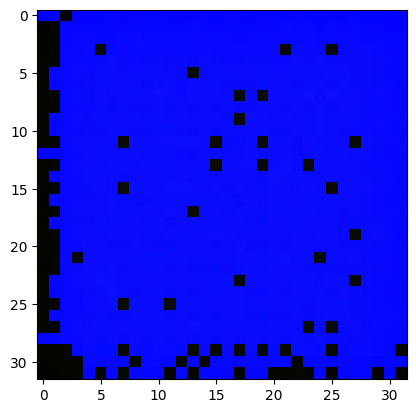

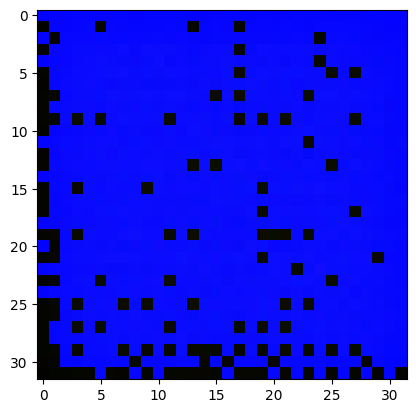

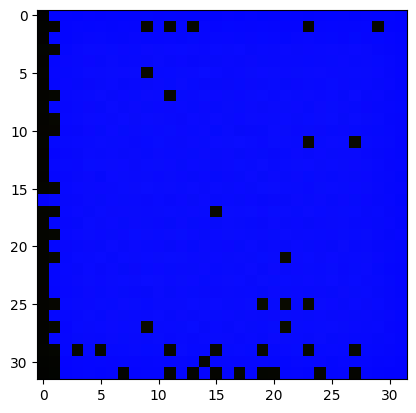

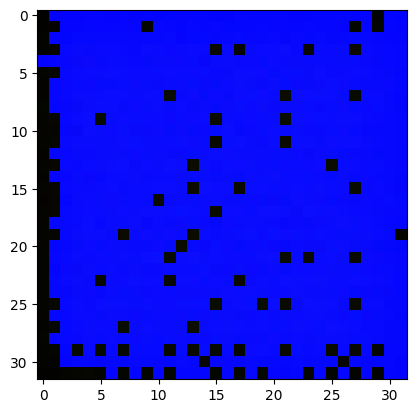

In [12]:
import matplotlib.pyplot as plt

# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()